In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Analyze data distribtuion

### Demographic information

<Axes: xlabel='2'>

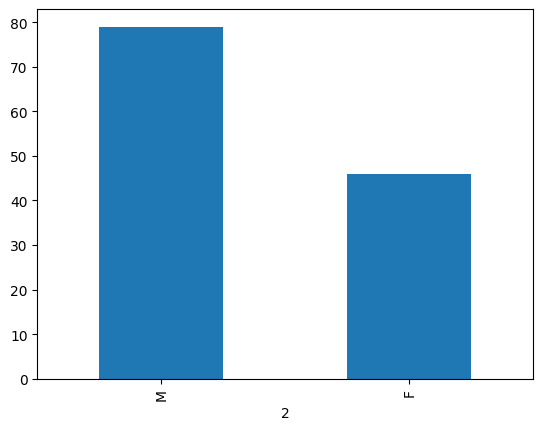

In [6]:
df_demo = pd.read_csv('../data/ICBHI_Challenge_demographic_information.txt', sep='\t', header=None)

# plot bar plot of column 2
df_demo[2].value_counts().plot(kind='bar')